# List ranking from incomplete pairwise preferences
** *
*Note: if you are visualizing this notebook directly from GitHub, some mathematical symbols might display incorrectly or not display at all, and the TOC links will not work. This same notebook can be rendered from nbviewer by following [this link.](http://nbviewer.ipython.org/github/david-cortes/pwlistorder/blob/master/example/pwlistorder_example.ipynb)*


This IPython notebook illustrates the usage of the Python package [pwlistorder](https://github.com/david-cortes/pwlistorder) with simulated data.

The problem to solve consists of ranking a list of items (from best to worst) based on pairwise preferences (i.e. data in the form of “Item A is preferred to Item B”) aggregated from many people, which are incomplete (not available for each pair of items) and biased (more likely to be observed for some items than for others). The methods here are nevertheless applicable to ranking items from complete or partial orderings from different people, as any ranked list can be decomposed into pairwise preferences between items (i.e. each item is preferred over all items that are below it in the ranking).

**Examples of this kind of data:**
* Ordered list of preferences for political candidates from different voters.
* Lists of top-N best artists/games/books/etc. from different users.
* Surveys asking people to compare a series of two items at a time (pick the better one).
* Clicks on a vertical ranked list of items shown in random orders to users, if we assume that a clicked item is preferred to items that were ranked above and seen by the user but not clicked  - overall idea is explained in [Bian, J., Long, B., Li, L., Moon, T., Dong, A., & Chang, Y. (2014). Exploiting User Preference for Online Learning in Web Content Optimization Systems. ACM Transactions on Intelligent Systems and Technology (TIST), 5(2), 33.](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Bian14Exploiting.pdf)


The rankings here are evaluated in terms of the pairwise preferences that they satisfy minus the pairwise preferences that they violate – from here on defined as their _score_. Thus, if we observe the following preferences: $ A\succ B, A\succ B, A\succ B, A\prec B $, then an ordering that puts A above B would get +2, whereas an ordering that puts B above A would get -2.

The goal is to reconstruct what the overall ranking of items is based on the observed preferences, and thus it is reasonable to assume that orderings with a higher such score are more representative of the overall real ranking than those with a lower score.
** *
## Sections

[1. What the data looks like](#p1)

[2. Simulating the data](#p2)

[3. Applying algorithms](#p3)

[4. Comparing these orderings to the simulation's underlying order](#p4)
* [4.1 Defining the metrics](#p41)
* [4.2 Evaluating the orderings](#p42)

[5. Ranking a larger list](#p5)
** *

<a id="p1"></a>
## 1. What the data looks like

This example will simulate data in the following way:
* There is a list of items, which have an overall attractiveness for users - this will be simulated as a random number for each item, with a bigger number meaning that the item is better, thus each item is comparable to each other.
* There are many users, each of which has different preferences for each item, but these tend to be similar across users – this will be simulated as a random number, from a distribution with less spread than the one for items, multiplied by the number reflecting the overall goodness of each item.
* Some items are easier to sample than others – that is, it’s easier or more common to get to know the preference for a user for some items than for others- and their probability is proportional to some randomly-generated numbers (~Beta(1,1)).
* The data available comes in the form of stated preferences between two products from different users – this will be simulated as picking two items and comparing their ‘goodness’ or ‘attractiveness’ as defined above, then adding which one was preferred to the data pool to work with.
* Overall, there is information only for some pairs of items, but not for all.
* Items and users are referred to by their numerical ID - this doesn't mean anything and is used only for identification purposes.

** *
## A look at some small simulated data


In [1]:
import numpy as np, pandas as pd
from random import shuffle

nusers=4
nitems=6

np.random.seed(10)
items=[i for i in range(nitems)]
item_probs=np.random.beta(a=1,b=1,size=nitems)
item_probs=item_probs/np.sum(item_probs)
item_goodness=np.random.beta(a=2,b=2,size=nitems)
user_preferences=[np.random.beta(a=3,b=3,size=nitems)*item_goodness for u in range(nusers)]
agg_item_goodness=np.zeros((nitems))
for u in range(nusers):
    agg_item_goodness+=user_preferences[u]

preferences=list()
for iteration in range(100):
    chosen_user=np.random.randint(low=0,high=nusers)
    for sample in range(3):
        chosen_items=np.random.choice(items,size=2,replace=False,p=item_probs)
        if chosen_items[0]==chosen_items[1]:
            continue
        goodness_A=user_preferences[chosen_user][chosen_items[0]]
        goodness_B=user_preferences[chosen_user][chosen_items[1]]
        if goodness_A>goodness_B:
            preferences.append((chosen_user,chosen_items[0],chosen_items[1]))
        else:
            preferences.append((chosen_user,chosen_items[1],chosen_items[0]))
            
shuffle(preferences)
pd.DataFrame(preferences, columns=['User','Prefers This Item','Over This Item']).head()

User  Prefers This Item  Over This Item
0     3                  3               0
1     2                  0               5
2     1                  0               1
3     0                  0               5
4     1                  0               3

These lists of preferences are aggregated by summing the number of times that preference “Item A is preferred to Item B” is observed and subtracting from it the number of times that preference “Item B is preferred to Item A” is observed.

The aggregated preferences are stored in a table reflecting the lower-triangular matrix of a full item x item matrix, thus the entry for “ItemA>ItemB” is in the cell [A,B] if the ID of item A is less than the ID of item B, and is -1 x cell [B,A] otherwise.

In [2]:
from collections import defaultdict

aggregated_preferences=defaultdict(lambda: 0)
for pref in preferences:
    if pref[1]<pref[2]:
        aggregated_preferences[(pref[1],pref[2])]+=1
    else:
        aggregated_preferences[(pref[2],pref[1])]-=1

# some preferences are hidden, thus some will be deleted at random here
for iteration in range(3):
    chosen_items=np.random.randint(low=0,high=nitems,size=2)
    if chosen_items[0]==chosen_items[1]:
        continue
    if chosen_items[0]<chosen_items[1]:
        del aggregated_preferences[(chosen_items[0],chosen_items[1])]
    else:
        aggregated_preferences[(chosen_items[1],chosen_items[0])]
aggregated_preferences

defaultdict(<function __main__.<lambda>>,
            {(0, 1): 54,
             (0, 2): 13,
             (0, 3): 27,
             (0, 5): 57,
             (1, 2): 1,
             (1, 3): -27,
             (1, 5): -35,
             (2, 3): 0,
             (2, 5): -12})

Ranking with these example preferences:

Best order: (0, 5, 2, 3, 1, 4)
Best score: 96
Theoretical maximum (perhaps not feasible): 226

Item goodness defined in simulation: [(0, 0.88), (5, 0.64), (4, 0.62), (3, 0.56), (2, 0.3), (1, 0.22)]
Item goodness across all users in simulation: [(0, 2.1), (4, 1.51), (5, 1.05), (3, 0.96), (2, 0.62), (1, 0.52)]


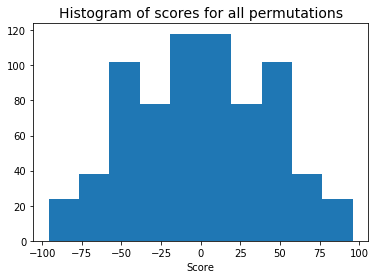

In [3]:
from itertools import permutations
from copy import deepcopy
from matplotlib import pyplot as plt
%matplotlib inline

def eval_ranking(order,aggregated_preferences):
    score=0
    for ind in range(len(order)-1):
        el1=order[ind]
        el2=order[ind+1]
        if el1<el2:
            score+=aggregated_preferences[(el1,el2)]
        else:
            score-=aggregated_preferences[(el2,el1)]
    return score

best_score=-100
worst_score=100
scores=list()
for order in permutations([i for i in range(nitems)]):
    score=eval_ranking(order,aggregated_preferences)
    scores.append(score)
    if score>best_score:
        best_score=deepcopy(score)
        best_order=order
        
print('Best order:',best_order)
print("Best score:",best_score)
print('Theoretical maximum (perhaps not feasible):',np.sum([np.abs(v) for v in aggregated_preferences.values()]))
print()
print('Item goodness defined in simulation:',[(el,eval("{0:.2f}".format(item_goodness[el]))) for el in np.argsort(-item_goodness)])
print('Item goodness across all users in simulation:',[(el,eval("{0:.2f}".format(agg_item_goodness[el]))) for el in np.argsort(-agg_item_goodness)])
_=plt.hist(np.array(scores))
_=plt.title('Histogram of scores for all permutations',size=14)
_=plt.xlabel('Score')

<a id="p2"></a>
## 2. Simulating the data

Let's now simulate a more realistic scenario:

* List of 30 items.
* Sample with replacement of random 300 users from a population of 500, with 4 preferences stated from each.
* Higher sampling bias (P~Beta(2,2)).
* Slightly less spread item goodness (~Beta(3,3)) and less spread user variation in preference (~Beta(4,4)).

In [4]:
nusers=500
nitems=30
aggregated_preferences=defaultdict(lambda: 0)

def add_preferences(el1,el2):
    global aggregated_preferences
    
    if el1<el2:
        aggregated_preferences[(el1,el2)]+=1
    else:
        aggregated_preferences[(el2,el1)]-=1

np.random.seed(100)
items=[i for i in range(nitems)]
item_probs=np.random.beta(a=2,b=2,size=nitems)
item_probs=item_probs/np.sum(item_probs)
item_goodness=np.random.beta(a=3,b=3,size=nitems)
user_preferences=[np.random.beta(a=4,b=4,size=nitems)*item_goodness for u in range(nusers)]
agg_item_goodness=np.zeros((nitems))
for u in range(nusers):
    agg_item_goodness+=user_preferences[u]

for iteration in range(300):
    chosen_user=np.random.randint(low=0,high=nusers)
    for sample in range(4):
        chosen_items=np.random.choice(items,size=2,replace=False,p=item_probs)
        if chosen_items[0]==chosen_items[1]:
            continue
        goodness_A=user_preferences[chosen_user][chosen_items[0]]
        goodness_B=user_preferences[chosen_user][chosen_items[1]]
        if goodness_A>goodness_B:
            add_preferences(chosen_items[0],chosen_items[1])
        else:
            add_preferences(chosen_items[1],chosen_items[0])
            
print('Theoretical maximum score:',np.sum([np.abs(v) for v in aggregated_preferences.values()]))
print('Number of pairwise preferences observed:',len([v for v in aggregated_preferences.values() if v!=0]))
print('Number of pairs in the list:',int(nitems*(nitems-1)/2))

Theoretical maximum score: 812
Number of pairwise preferences observed: 324
Number of pairs in the list: 435


<a id="p3"></a>
## 3. Applying algorithms

The example above with only 6 items found the best ordering by evaluating all the possible permutations of those 6 items, but such a brute-force search of all the orderings becomes infeasible when there are more than a dozen items (there are items! (factorial) possible orderings, so for example for 50 items there are 50!=3x10^64 different orderings).

As such, this larger 30-element list will be ranked with the algorithms implemented in the package, which won't necessarily find the best possible ordering, but make the problem tractable:

In [5]:
import time, random
from pwlistorder import (eval_ordering, greedy_order, kwiksort, pagerank,
                         cvx_relaxation, minconflict, random_swaps, metropolis_hastings)

#Generating a random ordering
np.random.seed(1)
random_ordering=deepcopy(items)
np.random.shuffle(random_ordering)

start_time = time.time()
greedy_rank=greedy_order(aggregated_preferences, random_ordering)
time_greedy_rank=time.time() - start_time

start_time = time.time()
ks_rank=kwiksort(aggregated_preferences, random_ordering, runs=100, random_seed=1)
time_kwiksort=time.time() - start_time

start_time = time.time()
pr_rank=pagerank(aggregated_preferences, len(random_ordering))
time_pagerank=time.time() - start_time

start_time = time.time()
cvxrelax_rank=cvx_relaxation(aggregated_preferences, len(random_ordering))
time_cvxrelax=time.time() - start_time

start_time = time.time()
mc_rank=minconflict(aggregated_preferences, random_ordering)
time_minconflict=time.time() - start_time

start_time = time.time()
rs_rank=random_swaps(aggregated_preferences, random_ordering, iterations=50000, random_seed=1)
time_random_swaps=time.time() - start_time

start_time = time.time()
mh_rank=metropolis_hastings(aggregated_preferences, random_ordering, iterations=50000, explore_fact=8, random_seed=1)
time_metropolis=time.time() - start_time

lst_scores={'Greedy Order':eval_ordering(greedy_rank,aggregated_preferences),
            'Kwik-Sort (100 trials)':eval_ordering(ks_rank,aggregated_preferences),
            'PageRank (tuned epsilon)':eval_ordering(pr_rank,aggregated_preferences),
            'Convex relaxation':eval_ordering(cvxrelax_rank,aggregated_preferences),
            'Min-Conflict':eval_ordering(mc_rank,aggregated_preferences),
            'Random Swaps':eval_ordering(rs_rank,aggregated_preferences),
            'Metropolis-Hastings Swapping':eval_ordering(mh_rank,aggregated_preferences)
           }
lst_times={'Greedy Order':time_greedy_rank,
            'Kwik-Sort (100 trials)':time_kwiksort,
            'PageRank (tuned epsilon)':time_pagerank,
            'Convex relaxation':time_cvxrelax,
            'Min-Conflict':time_minconflict,
            'Random Swaps':time_random_swaps,
            'Metropolis-Hastings Swapping':time_metropolis
           }

eval_df=pd.DataFrame.from_dict(lst_scores,orient='index').rename(columns={0:'Score'}).sort_values('Score',ascending=False)
runtimes=pd.DataFrame.from_dict(lst_times,orient='index').rename(columns={0:'Time (seconds)'})
eval_df.join(runtimes)

Score  Time (seconds)
Metropolis-Hastings Swapping    748        7.312418
Min-Conflict                    734        1.576090
Random Swaps                    728       21.423225
Convex relaxation               714        1.004057
Kwik-Sort (100 trials)          710        0.071004
PageRank (tuned epsilon)        660        0.073004
Greedy Order                    650        0.007000

<a id="p4"></a>
## 4. Comparing these orderings to the simulation's underlying order


Since these incomplete pairwise preferences were generated from a complete ranked list, it’s possible to evaluate them also in terms of how similar the order that they output is to the real ranking (in this case, we know it because we generated these samples from it plus a small disturbance to account for user preferences, but in a real situation, this ranking wouldn’t be available).


**Some good criteria for comparing one ranked list to another are:**

* The fraction of pairs ranked in same order relative to each other (e.g. if A is ranked above B in both lists, that pair adds to their similarity, whereas if A is ranked above B in one while B is ranked above A in another, it doesn’t add to their similarity).
* Symmetric AP correlation, described in [A new rank correlation coefficient for information retrieval](http://net.pku.edu.cn/~webg/src/paradise/reference/click-through%20evaluation/2008-SIGIR-A%20new%20rank%20correlation%20coefficient%20for%20information%20retrieval.pdf).

** *
<a id="p41"></a>
### 4.1 Defining the metrics

In [6]:
#implementing useful metrics
def fraction_conc_pairs(list1,list2):
    pairs_list1=set()
    for i in range(len(list1)-1):
        for j in range (i+1,len(list1)):
            pairs_list1.add((list1[i],list1[j]))
            
    p=0
    q=0
    for i in range(len(list2)-1):
        for j in range (i+1,len(list2)):
            if (list2[i],list2[j]) in pairs_list1:
                p+=1
            else:
                q+=1
    return p/(p+q)

def ap_cor(list1,list2):
    pairs_list2=set()
    p_prime=0
    for i in range(len(list2)-1):
        for j in range (i+1,len(list2)):
            pairs_list2.add((list2[i],list2[j]))
    
    for i in range(1,len(list1)):
        for j in range(i):
            if (list1[j],list1[i]) in pairs_list2:
                c=1
            else:
                c=0
            p_prime+=c/i
    p_prime=p_prime/(len(list1)-1)
    return p_prime-(1-p_prime)

def sym_ap_cor(list1,list2):
    return (ap_cor(list1,list2)+ap_cor(list2,list1))/2

<a id="p42"></a>
### 4.2 Evaluating the orderings

In [7]:
best_theoretical_order=list(np.argsort(-item_goodness))

lst_conc_pairs={'Greedy Order':'{:.2%}'.format(fraction_conc_pairs(greedy_rank,best_theoretical_order)),
            'Kwik-Sort (100 trials)':'{:.2%}'.format(fraction_conc_pairs(ks_rank,best_theoretical_order)),
            'PageRank (tuned epsilon)':'{:.2%}'.format(fraction_conc_pairs(pr_rank,best_theoretical_order)),
            'Convex relaxation':'{:.2%}'.format(fraction_conc_pairs(cvxrelax_rank,best_theoretical_order)),
            'Min-Conflict':'{:.2%}'.format(fraction_conc_pairs(mc_rank,best_theoretical_order)),
            'Random Swaps':'{:.2%}'.format(fraction_conc_pairs(rs_rank,best_theoretical_order)),
            'Metropolis-Hastings Swapping':'{:.2%}'.format(fraction_conc_pairs(mh_rank,best_theoretical_order))
           }
lst_sym_ap_cor={'Greedy Order':'{:.2%}'.format(sym_ap_cor(greedy_rank,best_theoretical_order)),
            'Kwik-Sort (100 trials)':'{:.2%}'.format(sym_ap_cor(ks_rank,best_theoretical_order)),
            'PageRank (tuned epsilon)':'{:.2%}'.format(sym_ap_cor(pr_rank,best_theoretical_order)),
            'Convex relaxation':'{:.2%}'.format(sym_ap_cor(cvxrelax_rank,best_theoretical_order)),
            'Min-Conflict':'{:.2%}'.format(sym_ap_cor(mc_rank,best_theoretical_order)),
            'Random Swaps':'{:.2%}'.format(sym_ap_cor(rs_rank,best_theoretical_order)),
            'Metropolis-Hastings Swapping':'{:.2%}'.format(sym_ap_cor(mh_rank,best_theoretical_order))
           }

eval_df=pd.DataFrame.from_dict(lst_scores,orient='index').rename(columns={0:'Score'}).sort_values('Score',ascending=False)
runtimes=pd.DataFrame.from_dict(lst_times,orient='index').rename(columns={0:'Time (seconds)'})
fcp=pd.DataFrame.from_dict(lst_conc_pairs,orient='index').rename(columns={0:'% concordant pairs w/generator'})
sapc=pd.DataFrame.from_dict(lst_sym_ap_cor,orient='index').rename(columns={0:'Symmetrical AP correlation w/generator'})
eval_df.join(runtimes).join(fcp).join(sapc)

Score  Time (seconds)  \
Metropolis-Hastings Swapping    748        7.312418   
Min-Conflict                    734        1.576090   
Random Swaps                    728       21.423225   
Convex relaxation               714        1.004057   
Kwik-Sort (100 trials)          710        0.071004   
PageRank (tuned epsilon)        660        0.073004   
Greedy Order                    650        0.007000   

                             % concordant pairs w/generator  \
Metropolis-Hastings Swapping                         86.90%   
Min-Conflict                                         86.67%   
Random Swaps                                         81.84%   
Convex relaxation                                    86.44%   
Kwik-Sort (100 trials)                               86.90%   
PageRank (tuned epsilon)                             83.45%   
Greedy Order                                         79.31%   

                             Symmetrical AP correlation w/generator  
Metropolis-Hastings Swapping                                 62.63%  
Min-Conflict                                                 66.71%  
Random Swaps                                                 54.92%  
Convex relaxation                                            64.14%  
Kwik-Sort (100 trials)                                       69.21%  
PageRank (tuned epsilon)                                     49.50%  
Greedy Order                                                 52.37%

Despite achieving lower scores, here Kwik-Sort managed to produce an ordering that is more similar to the underlying order form which the pairwise preferences were simulated. Metropolis-Hastings and Min-Conflict were quite close though, and the relative outcomes of algorithms would vary with a different simulation.

Taking a look at which elements do each put at the top and at the bottom – the numbers in each column reflect the item IDs and are ordered according to their rank under each ordering:

In [8]:
pd.DataFrame({"Simulation's order":best_theoretical_order,'Metropolis-Hastings Swapping':mh_rank,
              'PageRank':pr_rank, 'Convex relaxation':cvxrelax_rank, 'Min-Conflict':mc_rank,
              'Random Swaps':rs_rank,'Kwik-Sort (100 trials)':ks_rank,'Greedy Order':greedy_rank}).head(6)

Convex relaxation  Greedy Order  Kwik-Sort (100 trials)  \
0                 16            12                      16   
1                 13            10                      18   
2                 12            16                      12   
3                 18            25                      10   
4                 25            18                      13   
5                  0            24                      24   

   Metropolis-Hastings Swapping  Min-Conflict  PageRank  Random Swaps  \
0                            25            16        12            16   
1                            13            18        18            15   
2                            16            12        19            25   
3                            18            19        10            18   
4                            12            10         0            12   
5                            10            13        25            19   

   Simulation's order  
0                  16  
1                  18  
2                  12  
3                   4  
4                  25  
5                  14

In [9]:
pd.DataFrame({"Simulation's order":best_theoretical_order,'Metropolis-Hastings Swapping':mh_rank,
              'PageRank':pr_rank, 'Convex relaxation':cvxrelax_rank, 'Min-Conflict':mc_rank,
              'Random Swaps':rs_rank,'Kwik-Sort (100 trials)':ks_rank,'Greedy Order':greedy_rank}).tail(6)

Convex relaxation  Greedy Order  Kwik-Sort (100 trials)  \
24                 22            23                       7   
25                 29            28                      29   
26                 23             8                      23   
27                 28            19                      28   
28                  8             3                       8   
29                  3             0                       3   

    Metropolis-Hastings Swapping  Min-Conflict  PageRank  Random Swaps  \
24                            29            22        23            22   
25                            22            27         8            23   
26                            23             8        21            20   
27                            28            23        20            28   
28                             8            28         3             8   
29                             3             3        28             3   

    Simulation's order  
24                  11  
25                  27  
26                   8  
27                  23  
28                  28  
29                   3

<a id="p5"></a>
## 5. Ranking a larger list

The previous list only had 30 elements, and while this makes it infeasible to order by brute-force search, the problem is still smallish. Not all algorithms scale well with a bigger sample size.

Now doing the same but with a bigger simulation:
* 250 items.
* 3,000 sampled users (from an infinite population) with 5 preferences each.
* Same distribution for sampling bias, item goodness and variation in user preference.

This time there will only be information about pairwise preferences for 1/3 of the pairs of items. Since Min-Conflict scales poorly with the number of items, it won't be tried this time.

In [10]:
nitems=250
aggregated_preferences=defaultdict(lambda: 0)

np.random.seed(123)
items=[i for i in range(nitems)]
item_probs=np.random.beta(a=2,b=2,size=nitems)
item_probs=item_probs/np.sum(item_probs)
item_goodness=np.random.beta(a=3,b=3,size=nitems)
user_preferences=[np.random.beta(a=4,b=4,size=nitems)*item_goodness for u in range(nusers)]
agg_item_goodness=np.zeros((nitems))
for u in range(nusers):
    agg_item_goodness+=user_preferences[u]

for iteration in range(3000):
    prefs_user=np.random.beta(a=4,b=4,size=nitems)*item_goodness
    for sample in range(5):
        chosen_items=np.random.choice(items,size=2,replace=False,p=item_probs)
        if chosen_items[0]==chosen_items[1]:
            continue
        goodness_A=prefs_user[chosen_items[0]]
        goodness_B=prefs_user[chosen_items[1]]
        if goodness_A>goodness_B:
            add_preferences(chosen_items[0],chosen_items[1])
        else:
            add_preferences(chosen_items[1],chosen_items[0])
            
print('Theoretical maximum score:',np.sum([np.abs(v) for v in aggregated_preferences.values()]))
print('Number of pairwise preferences observed:',len([v for v in aggregated_preferences.values() if v!=0]))
print('Number of pairs in the list:',int(nitems*(nitems-1)/2))

Theoretical maximum score: 12716
Number of pairwise preferences observed: 10067
Number of pairs in the list: 31125


In [11]:
#Generating a random ordering
np.random.seed(1)
random_ordering=deepcopy(items)
np.random.shuffle(random_ordering)

start_time = time.time()
greedy_rank=greedy_order(aggregated_preferences, random_ordering)
time_greedy_rank=time.time() - start_time

start_time = time.time()
ks_rank=kwiksort(aggregated_preferences, random_ordering, runs=100, random_seed=1)
time_kwiksort=time.time() - start_time

start_time = time.time()
pr_rank=pagerank(aggregated_preferences, len(random_ordering))
time_pagerank=time.time() - start_time

start_time = time.time()
cvxrelax_rank=cvx_relaxation(aggregated_preferences, len(random_ordering))
time_cvxrelax=time.time() - start_time

start_time = time.time()
rs_rank=random_swaps(aggregated_preferences, random_ordering, iterations=50000, random_seed=1)
time_random_swaps=time.time() - start_time

start_time = time.time()
mh_rank=metropolis_hastings(aggregated_preferences, random_ordering, iterations=50000, explore_fact=8, random_seed=1)
time_metropolis=time.time() - start_time

best_theoretical_order=list(np.argsort(-item_goodness))

lst_scores={'Greedy Order':eval_ordering(greedy_rank,aggregated_preferences),
            'Kwik-Sort (100 trials)':eval_ordering(ks_rank,aggregated_preferences),
            'PageRank (tuned epsilon)':eval_ordering(pr_rank,aggregated_preferences),
            'Convex relaxation':eval_ordering(cvxrelax_rank,aggregated_preferences),
            'Random Swaps':eval_ordering(rs_rank,aggregated_preferences),
            'Metropolis-Hastings Swapping':eval_ordering(mh_rank,aggregated_preferences)
           }
lst_times={'Greedy Order':time_greedy_rank,
            'Kwik-Sort (100 trials)':time_kwiksort,
            'PageRank (tuned epsilon)':time_pagerank,
            'Convex relaxation':time_cvxrelax,
            'Random Swaps':time_random_swaps,
            'Metropolis-Hastings Swapping':time_metropolis
           }

lst_conc_pairs={'Greedy Order':'{:.2%}'.format(fraction_conc_pairs(greedy_rank,best_theoretical_order)),
            'Kwik-Sort (100 trials)':'{:.2%}'.format(fraction_conc_pairs(ks_rank,best_theoretical_order)),
            'PageRank (tuned epsilon)':'{:.2%}'.format(fraction_conc_pairs(pr_rank,best_theoretical_order)),
            'Convex relaxation':'{:.2%}'.format(fraction_conc_pairs(cvxrelax_rank,best_theoretical_order)),
            'Random Swaps':'{:.2%}'.format(fraction_conc_pairs(rs_rank,best_theoretical_order)),
            'Metropolis-Hastings Swapping':'{:.2%}'.format(fraction_conc_pairs(mh_rank,best_theoretical_order))
           }
lst_sym_ap_cor={'Greedy Order':'{:.2%}'.format(sym_ap_cor(greedy_rank,best_theoretical_order)),
            'Kwik-Sort (100 trials)':'{:.2%}'.format(sym_ap_cor(ks_rank,best_theoretical_order)),
            'PageRank (tuned epsilon)':'{:.2%}'.format(sym_ap_cor(pr_rank,best_theoretical_order)),
            'Convex relaxation':'{:.2%}'.format(sym_ap_cor(cvxrelax_rank,best_theoretical_order)),
            'Random Swaps':'{:.2%}'.format(sym_ap_cor(rs_rank,best_theoretical_order)),
            'Metropolis-Hastings Swapping':'{:.2%}'.format(sym_ap_cor(mh_rank,best_theoretical_order))
           }

eval_df=pd.DataFrame.from_dict(lst_scores,orient='index').rename(columns={0:'Score'}).sort_values('Score',ascending=False)
runtimes=pd.DataFrame.from_dict(lst_times,orient='index').rename(columns={0:'Time (seconds)'})
fcp=pd.DataFrame.from_dict(lst_conc_pairs,orient='index').rename(columns={0:'% concordant pairs w/generator'})
sapc=pd.DataFrame.from_dict(lst_sym_ap_cor,orient='index').rename(columns={0:'Symmetrical AP correlation w/generator'})
eval_df.join(runtimes).join(fcp).join(sapc)

Score  Time (seconds)  \
Metropolis-Hastings Swapping   9010       51.729959   
Random Swaps                   9006      150.461606   
Convex relaxation              8396      154.081813   
PageRank (tuned epsilon)       7568        2.434139   
Greedy Order                   7292        3.523201   
Kwik-Sort (100 trials)         5778        2.915167   

                             % concordant pairs w/generator  \
Metropolis-Hastings Swapping                         87.73%   
Random Swaps                                         88.46%   
Convex relaxation                                    92.52%   
PageRank (tuned epsilon)                             82.59%   
Greedy Order                                         77.77%   
Kwik-Sort (100 trials)                               70.22%   

                             Symmetrical AP correlation w/generator  
Metropolis-Hastings Swapping                                 60.27%  
Random Swaps                                                 62.47%  
Convex relaxation                                            73.78%  
PageRank (tuned epsilon)                                     49.81%  
Greedy Order                                                 45.54%  
Kwik-Sort (100 trials)                                       29.42%

This time, Kwik-Sort didn't fare so well with this larger and more sparse input data, and the convex relaxation of the problem with l1 penalty seemed to reconstruct an order closest to the original. Metropolis-Hastings again did well both in terms of score and correlation with the real order behind the simulation.

Again taking a look at which elements do each put at the top and at the bottom – the numbers in each column reflect the item IDs and are ordered according to their rank under each ordering:

In [12]:
pd.DataFrame({"Simulation's order":best_theoretical_order,'Metropolis-Hastings Swapping':mh_rank,
              'PageRank':pr_rank, 'Convex relaxation':cvxrelax_rank,
              'Random Swaps':rs_rank,'Kwik-Sort (100 trials)':ks_rank,'Greedy Order':greedy_rank}).head(15)

Convex relaxation  Greedy Order  Kwik-Sort (100 trials)  \
0                 222             8                     205   
1                  77             7                     212   
2                 207           203                      77   
3                 107           127                     201   
4                 233           232                     152   
5                  50            39                      42   
6                   8            92                      41   
7                 170           226                     206   
8                  31           231                     193   
9                  16           242                       1   
10                 97           154                     226   
11                 25           165                      36   
12                232            34                      81   
13                 36           161                      31   
14                 39           107                     161   

    Metropolis-Hastings Swapping  PageRank  Random Swaps  Simulation's order  
0                            207        52           222                  50  
1                             31       152           124                 232  
2                             97       206            77                 152  
3                             16       233           161                  77  
4                             77        97           226                   8  
5                            233        50            16                  36  
6                            170        77           236                  86  
7                            161       186           207                  16  
8                             39       222           233                  39  
9                              0         6           227                 233  
10                             7       212           107                 222  
11                            25         0            79                 203  
12                           107       170            97                 207  
13                             1         1           170                 167  
14                            79        16            60                 236

In [13]:
pd.DataFrame({"Simulation's order":best_theoretical_order,'Metropolis-Hastings Swapping':mh_rank,
              'PageRank':pr_rank, 'Convex relaxation':cvxrelax_rank,
              'Random Swaps':rs_rank,'Kwik-Sort (100 trials)':ks_rank,'Greedy Order':greedy_rank}).tail(15)

Convex relaxation  Greedy Order  Kwik-Sort (100 trials)  \
235                229            32                     138   
236                157            78                     114   
237                 47            51                      49   
238                 64           220                     125   
239                 32            97                     235   
240                239             2                     246   
241                178           248                     139   
242                125            15                     171   
243                199           206                      75   
244                 15            80                      69   
245                213            52                      14   
246                118           213                      59   
247                 69           209                     187   
248                209            79                     118   
249                 51           140                     209   

     Metropolis-Hastings Swapping  PageRank  Random Swaps  Simulation's order  
235                            52       239           125                  64  
236                           184        12           239                  32  
237                           187       197            35                 125  
238                           159       173           157                 178  
239                           178       171           184                  15  
240                           199       184           118                 157  
241                           157       229           159                 159  
242                           125       157           178                 199  
243                            69       104            69                 230  
244                            64        47            32                 118  
245                            15       118            51                 229  
246                           113        51            64                 213  
247                            32       178           213                  51  
248                           209        69           140                  69  
249                            51       209           209                 209